# Lecture 04 - Categories & Curves

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import xarray as xr
import arviz as az
import utils as utils
from scipy import stats as stats
from matplotlib import pyplot as plt
import pytensor
Watermark:
----------
Last updated: 2025-11-28T15:30:47.912513+07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.36.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

watermark  : 2.5.0
numpy      : 1.25.2
scipy      : 1.12.0
statsmodels: 0.14.4
pytensor   : 2.15.0
xarray     : 2025.4.0
matplotlib : 3.10.1
arviz      : 0.16.1
IPython    : 8.36.0
pymc       : 5.8.0
pandas     : 2.2.3



## Linear Regression & Drawing Inferences
- Can be used to approximate most anything, even nonlinear phenomena (e.g. GLMs)
- We need to incorporate causal thinking into...
    - ...how we compose statistical models
    - ...how we process and interpre results

## Categories
- non-continuous causes
- discrete, unordered types
- stratifying by category: fit a separate regression (e.g. line) to each

### Revisiting the Howell dataset

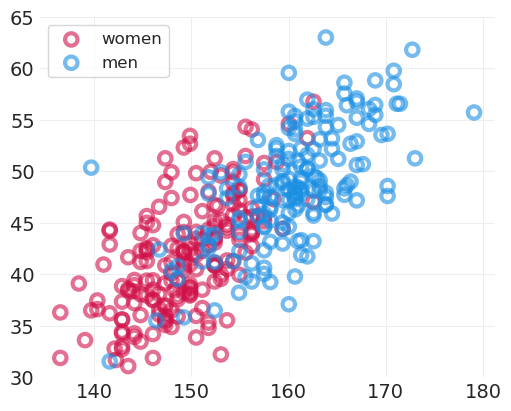

In [2]:
HOWELL = utils.load_data("Howell1")

# Adult data
ADULT_HOWELL = HOWELL[HOWELL.age >= 18]

# Split by the Sex category
SEX = ['women', 'men']

plt.subplots(figsize = (5, 4))
for ii, label in enumerate(SEX):
    utils.plot_scatter(
        ADULT_HOWELL[ADULT_HOWELL.male == ii].height,
        ADULT_HOWELL[ADULT_HOWELL.male == ii].weight,
        color = f"C{ii}",
        label = label
    )
plt.ylim([30, 65])
plt.legend()

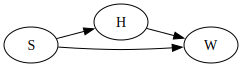

In [3]:
# Draw the mediation graph
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W")
    ],
    graph_direction="LR"
)

### Think scientifically first
- How are height, weight, and sex **causally** related?
- How are height, weight, and sex **statistically** related? 

### The causes aren't in the data
Height should affect weight, not vice versa
- ✅ $H \rightarrow W$
- ❌ $H \leftarrow W$

Sex should affect height, not vice versa
- ❌ $H \rightarrow S$
- ✅ $H \leftarrow S$


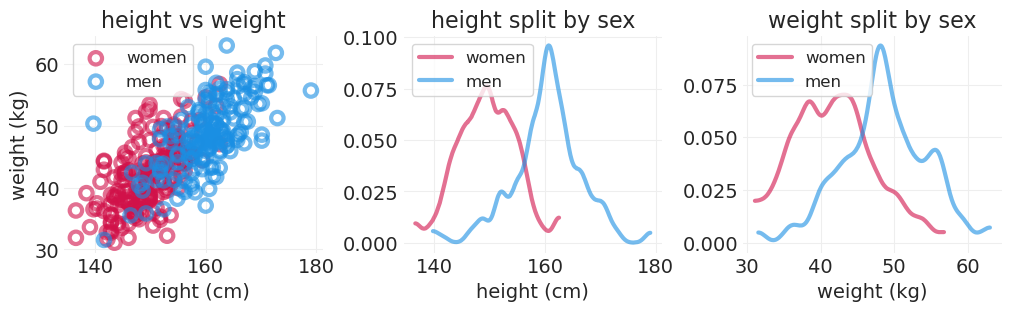

In [4]:
# Split height by the Sex Category
def plot_height_weight_distributions(data):
    fig, axs = plt.subplots(1, 3, figsize = (10, 3))
    plt.sca(axs[0])
    
    for ii, label in enumerate(SEX):
        utils.plot_scatter(
            data[data.male == ii].height,
            data[data.male == ii].weight,
            color = f"C{ii}",
            label = label,
        )
    plt.xlabel("height (cm)")
    plt.ylabel("weight (kg)")
    plt.legend()
    plt.title("height vs weight")
    
    for vv, var in enumerate(['height', 'weight']):
        plt.sca(axs[vv+1])
        for ii in range(2):
            az.plot_dist(
                data.loc[data.male == ii, var].values,
                color = f"C{ii}",
                label = SEX[ii],
                bw = 1,
                plot_kwargs = dict(linewidth = 3, alpha = .6),
            )
        if var == "height":
            plt.title(f"height split by sex")
            plt.xlabel(f"height (cm)")
        else:
            plt.title(f"weight split by sex")
            plt.xlabel(f"weight (kg)")
        plt.legend();
        
plot_height_weight_distributions(ADULT_HOWELL)

Causal graph defines a set of functional relationships

$$
\begin{align}
    H & = f_H(S) \\
    W & = f_W(H, S)
\end{align}
$$

Could also include unobservable causal influences $T$ on $S$ (see below graph):

$$
\begin{align}
    H & = f_H(S, U) \\
    W & = f_W(H, S, V) \\
    S & = f_S(T)
\end{align}
$$

> Note: we use $T$ as an unobserved variable, rather than $W$ to avoid replocation in the lecture

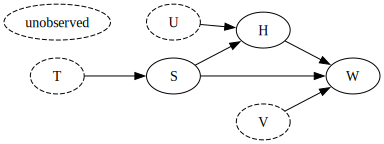

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
        ("V", "W"),
        ("U", "H"),
        ("T", "S")
    ],
    node_props={
        "T": {"style": "dashed"},
        "U": {"style": "dashed"},
        "V": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

#### Synthetic People

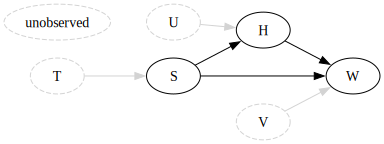

In [6]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
        ("V", "W"),
        ("U", "H"),
        ("T", "S")
    ],
    node_props={
        "T": {"style": "dashed", "color": "lightgray"},
        "U": {"style": "dashed", "color": "lightgray"},
        "V": {"style": "dashed", "color": "lightgray"},
        "unobserved": {"style": "dashed", "color": "lightgray"}
    },
    edge_props={
        ("T", "S"): {"color": "lightgray"},
        ("U", "H"): {"color": "lightgray"},
        ("V", "W"): {"color": "lightgray"}
    },
    graph_direction="LR"
)

,height,weight,male
0,149.143643,137.962179,0
1,154.887153,157.060224,1
2,163.648003,160.389836,1
3,158.320793,157.664743,1
4,148.592047,147.735554,1


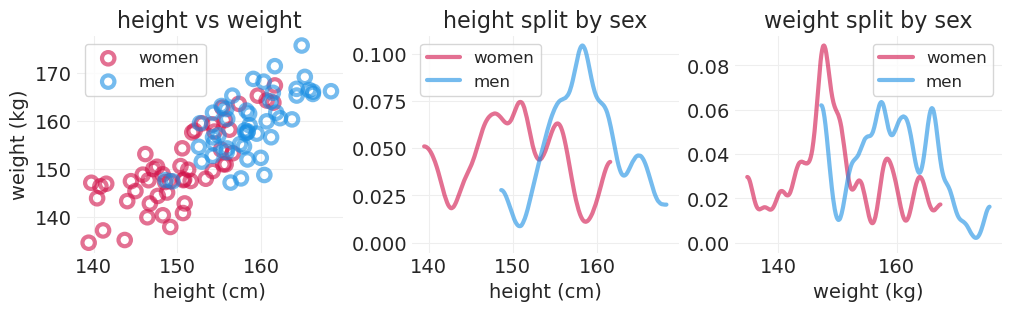

In [7]:
def simulate_sex_height_weight(
    S: np.ndarray,
    beta: np.ndarray = np.array([1, 1]),
    alpha: np.ndarray = np.array([0, 0]),
    female_mean_height: float = 150,
    male_mean_height: float = 160
) -> np.ndarray:
    """
    Generative model for the effect of Sex on height & weight
    
    S: np.array[int]
        The 0/1 indicator variable sex. 1 means 'male'
    beta: np.array[float]
        Length 2 slope coefficient for each sex
    alpha: np.array[float]
        Length 2 intercept for each sex
    """
    N = len(S)
    H = np.where(S, male_mean_height, female_mean_height) + stats.norm(0, 5).rvs(size=N)
    W = alpha[S] + beta[S] * H + stats.norm(0, 5).rvs(size=N)
    
    return pd.DataFrame({"height": H, "weight": W, "male": S})

synthetic_sex = stats.bernoulli(p=.5).rvs(size=100).astype(int)
synthetic_people = simulate_sex_height_weight(S=synthetic_sex)
plot_height_weight_distributions(synthetic_people)
synthetic_people.head()

#### Think scientifically first
Different causal questions require different statistical models:
- Question 1: What's the causal effect of $H$ and $W$?
- Question 2: What's the **Total** Causal effect of $S$ on $W$?
- Question 3: What's the **Direct** Causal effect of $S$ on $W$?

Answering the last two questions requires different statistical models, but both will need stratification by $S$

#### From estimand to estimate

##### Causal effect of $H$ on $W$ (Q1)

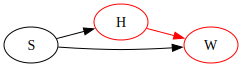

In [8]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "H": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("H", "W"): {"color": "red"},
    },
    graph_direction="LR"
)

##### **Total** Causal effect of $S$ on $W$

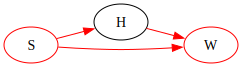

In [9]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "W"): {"color": "red"},
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

##### **Direct** Causal effect of $S$ on $W$ (Q3)

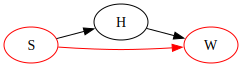

In [10]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

**Stratify by S**: recover a different estimate for each value that $S$ can take

#### Drawing the Causal Owl 🦉
Implement Categories via **Indicator Variables**
- generalizes code: can extend to any number of categories
- better for prior specification
- facilitates multi-level model specification

For categories $C = [C_1, C_2, ... C_D]$

$$
\begin{align}
    \alpha & = [\alpha_1, \alpha_2, ... \alpha_D] \\
    y_i & \sim \operatorname{Normal}(\mu_i, \sigma) \\
    \mu_i = \alpha_{C[i]}
\end{align}
$$

For sex $S \in \{M, F\}$, we can model sex-specific weight $W$ as

$$
\begin{align}
    W_i  & \sim \operatorname{Normal}(\mu_i, \sigma) \\
    \mu_i & = \alpha_{S[i]} \\
    \alpha & = [\alpha_F, \alpha_M] \\
    \alpha_j  & \sim \operatorname{Normal}(60, 10) \\
    sigma  & \sim \operatorname{Uniform}(0, 10)
\end{align}
$$

### Testing
#### Total Causal Effect of Sex on Weight

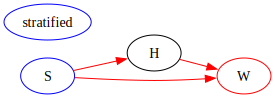

In [11]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "blue"},
        "W": {"color": "red"},
        "stratified": {"color": "blue"}
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "W"): {"color": "red"},
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

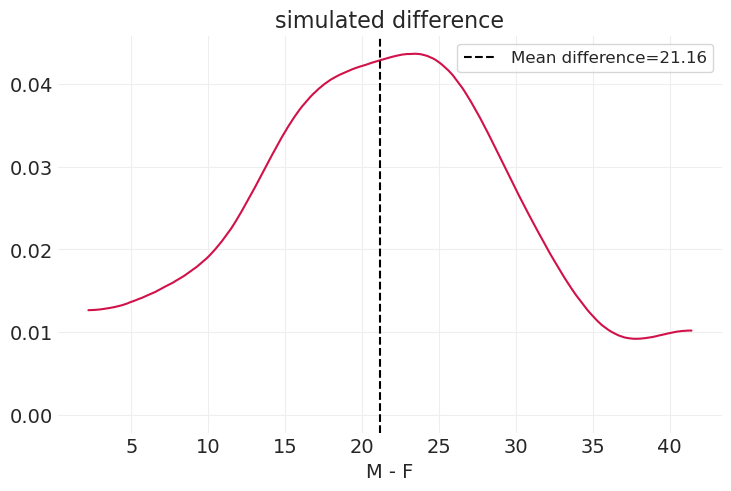

In [12]:
np.random.seed(12345)
n_simulations = 100
simulated_females = simulate_sex_height_weight(
    S=np.zeros(n_simulations).astype(int),
    beta=np.array((0.5, 0.6))
)

simulated_males = simulate_sex_height_weight(
    S=np.ones(n_simulations).astype(int),
    beta=np.array((0.5, 0.6))
)

simulated_delta = simulated_males - simulated_females
mean_simulated_delta = simulated_delta.mean()
az.plot_dist(simulated_delta['weight'].values)
plt.axvline(
    mean_simulated_delta['weight'],
    linestyle='--',
    color='k',
    label="Mean difference" + f"={mean_simulated_delta['weight']:1.2f}"
)
plt.xlabel("M - F")
plt.legend()
plt.title("simulated difference");

#### Fit total effect on the synthetic sample
Stratify by $S$

In [13]:
def fit_total_effect_model(data):
    
    SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])
    
    with pm.Model(coords={"SEX": SEX}) as model:
        # Data
        S = pm.MutableData("S", SEX_ID)
        
        # Priors
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 60, 10, dims="SEX")
        
        # Likelihood
        mu = alpha[S]
        pm.Normal("W_obs", mu, sigma, observed=data["weight"])
        
        inference = pm.sample()
        
    return inference, model

# Concatenate simulations and code sex
simulated_people = pd.concat([simulated_females, simulated_males])
simulated_total_effect_inference, simulated_total_effect_model = fit_total_effect_model(simulated_people)
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
simulated_summary = az.summary(simulated_total_effect_inference, var_names=['alpha', 'sigma'])
simulated_delta = (simulated_summary.iloc[1] - simulated_summary.iloc[0])['mean']
print(f"Delta in average sex-specific weight: {simulated_delta:1.2f}")

simulated_summary

Delta in average sex-specific weight: 21.07


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[F],74.860,0.582,73.698,75.868,0.007,0.005,6526.0,3359.0,1.0
alpha[M],95.932,0.592,94.724,96.974,0.007,0.005,6475.0,3107.0,1.0
sigma,5.916,0.303,5.353,6.486,0.004,0.003,5174.0,2992.0,1.0


In [15]:
# Plotting helper function
def plot_model_posterior(inference, effect_type: str = "Total"):
    np.random.seed(123)
    sex = ['F', 'M']
    posterior = inference.posterior
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Posterior mean
    plt.sca(axs[0][0])
    for ii, s in enumerate(sex):
        posterior_mean = posterior["alpha"].sel(SEX=s).mean(dim='chain')
        az.plot_dist(posterior_mean, color=f"C{ii}", label=s, plot_kwargs=dict(linewidth=3))
        
    plt.xlabel("posterior mean weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior $\\alpha_S$")
    
    # Posterior Predictive
    plt.sca(axs[0][1])
    posterior_prediction_std = posterior["sigma"].mean(dim=['chain'])
    posterior_prediction = {}
    
    for ii, s in enumerate(sex):
        posterior_prediction_mean = posterior.sel(SEX=s)["alpha"].mean(dim=['chain'])
        posterior_prediction[s] = stats.norm.rvs(posterior_prediction_mean, posterior_prediction_std)
        az.plot_dist(posterior_prediction[s], color=f"C{ii}", label=s, plot_kwargs=dict(linewidth=3))
        
    plt.xlabel("posterior predicted weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior Predictive")
    
    # Plot Contrasts
    ## Posterior Contrast
    plt.sca(axs[1][0])
    posterior_contrast = posterior.sel(SEX='M')["alpha"] - posterior.sel(SEX='F')["alpha"]
    az.plot_dist(posterior_contrast, color='k', plot_kwargs=dict(linewidth=3))
    plt.xlabel("$\\alpha_M$ - $\\alpha_F$ posterior mean weight contrast")
    plt.ylabel("density")
    plt.title("Posterior Contrast")
    
    ## Posterior Predictive Contrast
    plt.sca(axs[1][1])
    posterior_predictive_contrast = posterior_prediction['M'] - posterior_prediction['F']
    n_draws = len(posterior_predictive_contrast)
    kde_ax = az.plot_dist(posterior_predictive_contrast, color='k', bw=1, plot_kwargs=dict(linewidth=3))
    
    # Shade underneath posterior predictive contrast
    kde_x, kde_y = kde_ax.get_lines()[0].get_data()
    
    # Proportion of PPD contrast below zero
    neg_idx = kde_x < 0
    neg_prob = 100 * np.sum(posterior_predictive_contrast < 0) / n_draws
    plt.fill_between(
        x=kde_x[neg_idx],
        y1=np.zeros(sum(neg_idx)),
        y2=kde_y[neg_idx],
        color='C0',
        label=f"{neg_prob:1.0f}"
    )
    
    # Proportion of PPD contrast above zero (inclusive)
    pos_idx = kde_x >= 0
    pos_prob = 100 * np.sum(posterior_predictive_contrast >= 0) / n_draws
    plt.fill_between(
        x=kde_x[pos_idx],
        y1=np.zeros(sum(pos_idx)),
        y2=kde_y[pos_idx],
        color='C1',
        label=f"{pos_prob:1.0f}"
    )
    
    plt.xlabel("(M - F)\nposterior prediction contrast")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior\nPredictive Contrast");
    plt.suptitle(f"{effect_type} Causal Effect of Sex on Weight", fontsize=18)
    
def plot_posterior_lines(data, inference, centered=False):
    plt.subplots(figsize=(6, 6))
    
    min_height = data.height.min()
    max_height = data.height.max()
    xs = np.linspace(min_height, max_height, 10)
    for ii, s in enumerate(['F', 'M']):
        sex_idx = data.male == ii
        utils.plot_scatter(
            xs = data[sex_idx].height,
            ys = data[sex_idx].weight,
            color = f"C{ii}",
            label = s
        )
        
        posterior_mean = inference.posterior.sel(SEX = s).mean(dim = ('chain', 'draw'))
        posterior_mean_alpha = posterior_mean['alpha'].values
        posterior_mean_beta = getattr(posterior_mean, 'beta', pd.Series([0])).values
        
        if centered:
            pred_x = xs - data.height.mean()
        else:
            pred_x = xs

        ys = posterior_mean_alpha + posterior_mean_beta * pred_x
        utils.plot_line(xs, ys, label = None, color = f"C{ii}")
        
    # Model fit to both sexes simultaneously
    global_model = smf.ols("weight ~ height", data = data).fit()
    ys = global_model.params.Intercept + global_model.params.height * xs
    utils.plot_line(xs, ys, color = 'k', label = 'Unstratified\nModel')
    
    plt.axvline(
        data["height"].mean(),
        label = 'Average H',
        linewidth = 0.5, linestyle = '--', color = 'black'
    )
    plt.axhline(
        data["weight"].mean(),
        label = "Average W",
        linewidth = 1, linestyle = '--', color = 'black'
    )
    plt.legend()
    plt.xlabel("height (cm), H")
    plt.ylabel("weight (kg) W");

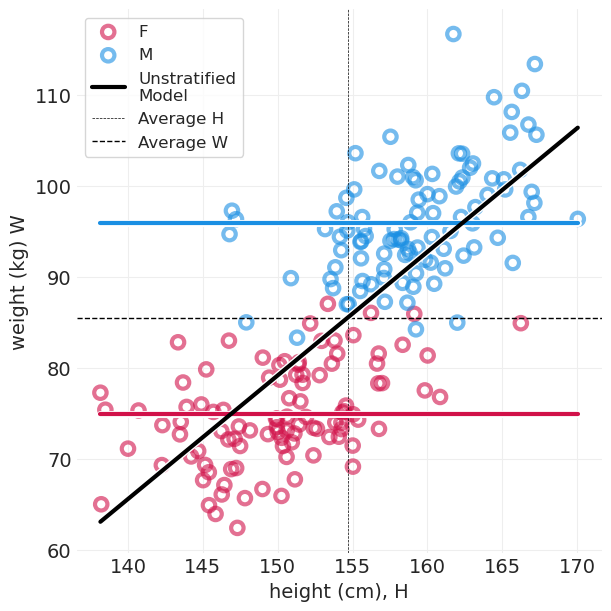

In [16]:
plot_posterior_lines(simulated_people, simulated_total_effect_inference, centered = True)

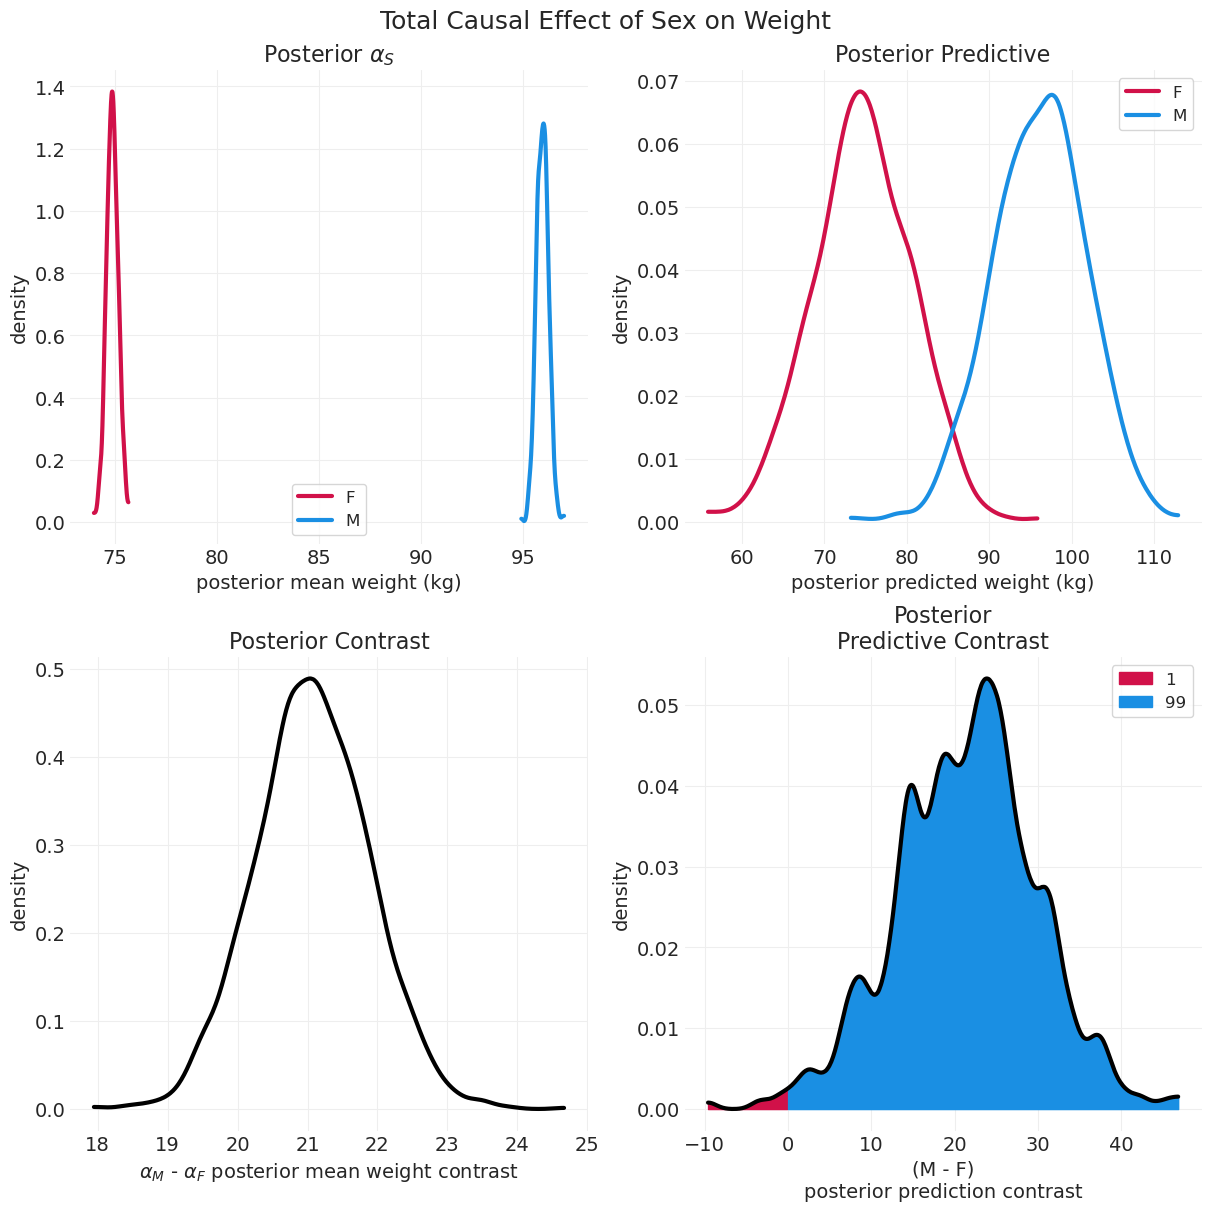

In [17]:
plot_model_posterior(simulated_total_effect_inference)

#### Analyze real sample

In [18]:
adult_howell_total_effect_inference, adult_howell_total_effect_model = fit_total_effect_model(ADULT_HOWELL)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [19]:
adult_howell_total_effect_summary = az.summary(adult_howell_total_effect_inference, var_names=['alpha'])
adult_howell_total_effect_delta = (adult_howell_total_effect_summary.iloc[1] - adult_howell_total_effect_summary.iloc[0])['mean']
print(f"Delta in average sex-specific weight: {adult_howell_total_effect_delta:1.2f}")

adult_howell_summary = az.summary(adult_howell_total_effect_inference)
adult_howell_summary

Delta in average sex-specific weight: -6.77


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[M],48.618,0.444,47.820,49.465,0.006,0.004,6042.0,2882.0,1.0
alpha[F],41.846,0.408,41.105,42.610,0.005,0.004,5828.0,2881.0,1.0
sigma,5.527,0.208,5.140,5.911,0.003,0.002,6659.0,2852.0,1.0


#### Always be contrasting
- need compare the **contrast** between categories
- **never valid to calculate overlap** in distributions
    - this means **no comparing confidence intervals for p-values**
- Compute the difference of distributions -- the **contract distribution**

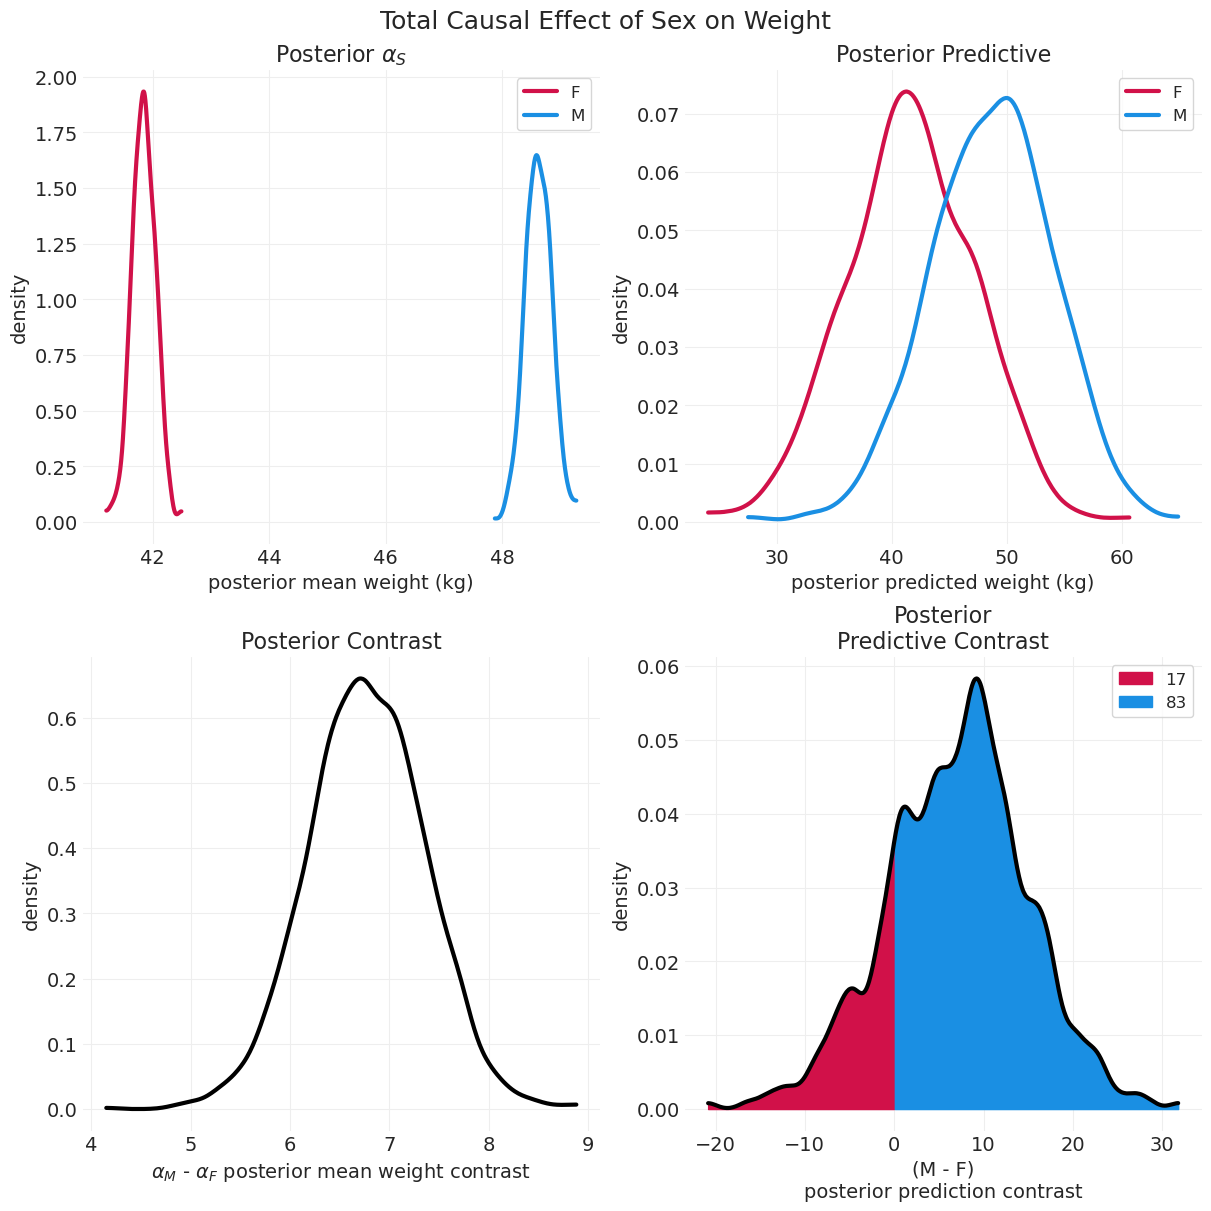

In [20]:
plot_model_posterior(adult_howell_total_effect_inference)

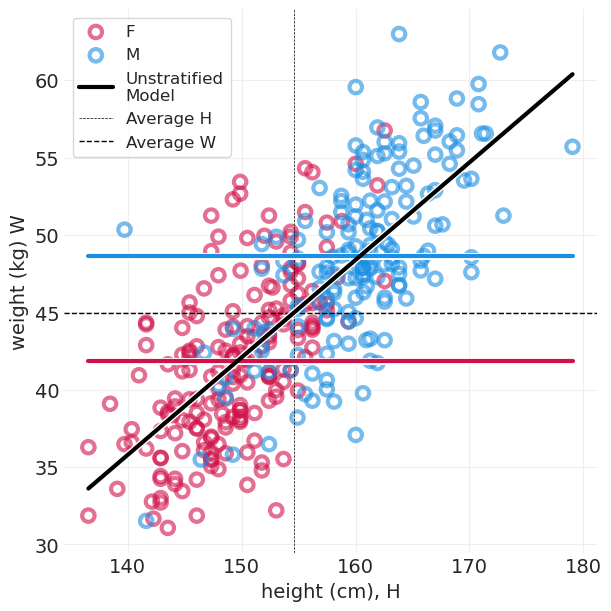

In [21]:
plot_posterior_lines(ADULT_HOWELL, adult_howell_total_effect_inference, True)

#### **Direct** causal effect of $S$ on $W$?

We need another model/estimator for this estimand. We stratify by both $S$ and $H$; by $H$ to block the path of $S$ through $H$

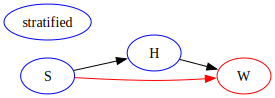

In [22]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "blue"},
        "W": {"color": "red"},
        "H": {"color": "blue"},
        "stratified": {"color": "blue"}
    },
    edge_props={
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

$$
\begin{align}
W_i & \sim \operatorname{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha_{S[i]} + \beta_{S[i]}(H_i - \bar{H})
\end{align}
$$

Where we've **centered the height**, meaning that
- $\beta$ scales the difference of $H_i$ from the average height
- $\alpha$ is the weight when a person is the average height
- Global model fit to all data lies at the intersection of global average height and weight

#### Simulate some more people

In [23]:
ALPHA = 0.9
np.random.seed(1234)
n_synthetic_people = 200

syntetic_sex = stats.bernoulli.rvs(p = .5, size = n_synthetic_people)
synthetic_people = simulate_sex_height_weight(
    S = syntetic_sex,
    beta = np.array([0.5, 0.5]), # Same relationship between height & weight
    alpha = np.array([0.0, 10]) # 10kg "boost for Males"
)

#### Analyze the synthetic people

In [24]:
def fit_direct_effect_weight_model(data):

    SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])

    with pm.Model(coords={"SEX": SEX}) as model:
        # Data
        S = pm.MutableData("S", SEX_ID, dims="obs_ids")
        H = pm.MutableData("H", data["height"].values, dims="obs_ids")
        Hbar = pm.MutableData("Hbar", data["height"].mean())

        # Priors
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 60, 10, dims="SEX")
        beta = pm.Uniform("beta", 0, 1, dims="SEX")  # postive slopes only

        # Likelihood
        mu = alpha[S] + beta[S] * (H - Hbar)
        pm.Normal("W_obs", mu, sigma, observed=data["weight"].values, dims="obs_ids")

        inference = pm.sample()
        
    return inference, model

In [25]:
direct_effect_simulated_inference, direct_effect_simulated_model = fit_direct_effect_weight_model(simulated_people)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


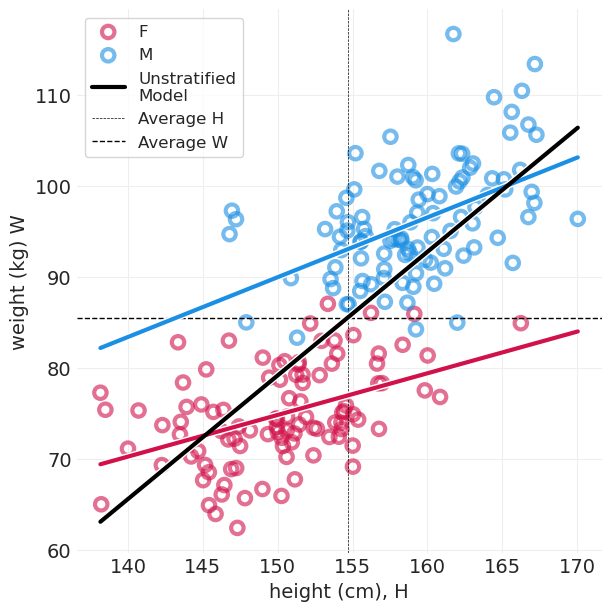

In [26]:
plot_posterior_lines(simulated_people, direct_effect_simulated_inference, centered=True)

- **Indirect effect**: M & F have specific slopes - in this simulation, they are the same slope, thus parallel lines
- **Direct effect**: There will be a delta, no matter the slope. -- in this simulation $S = M$ are always 10kg heavier, thus blue is always above red

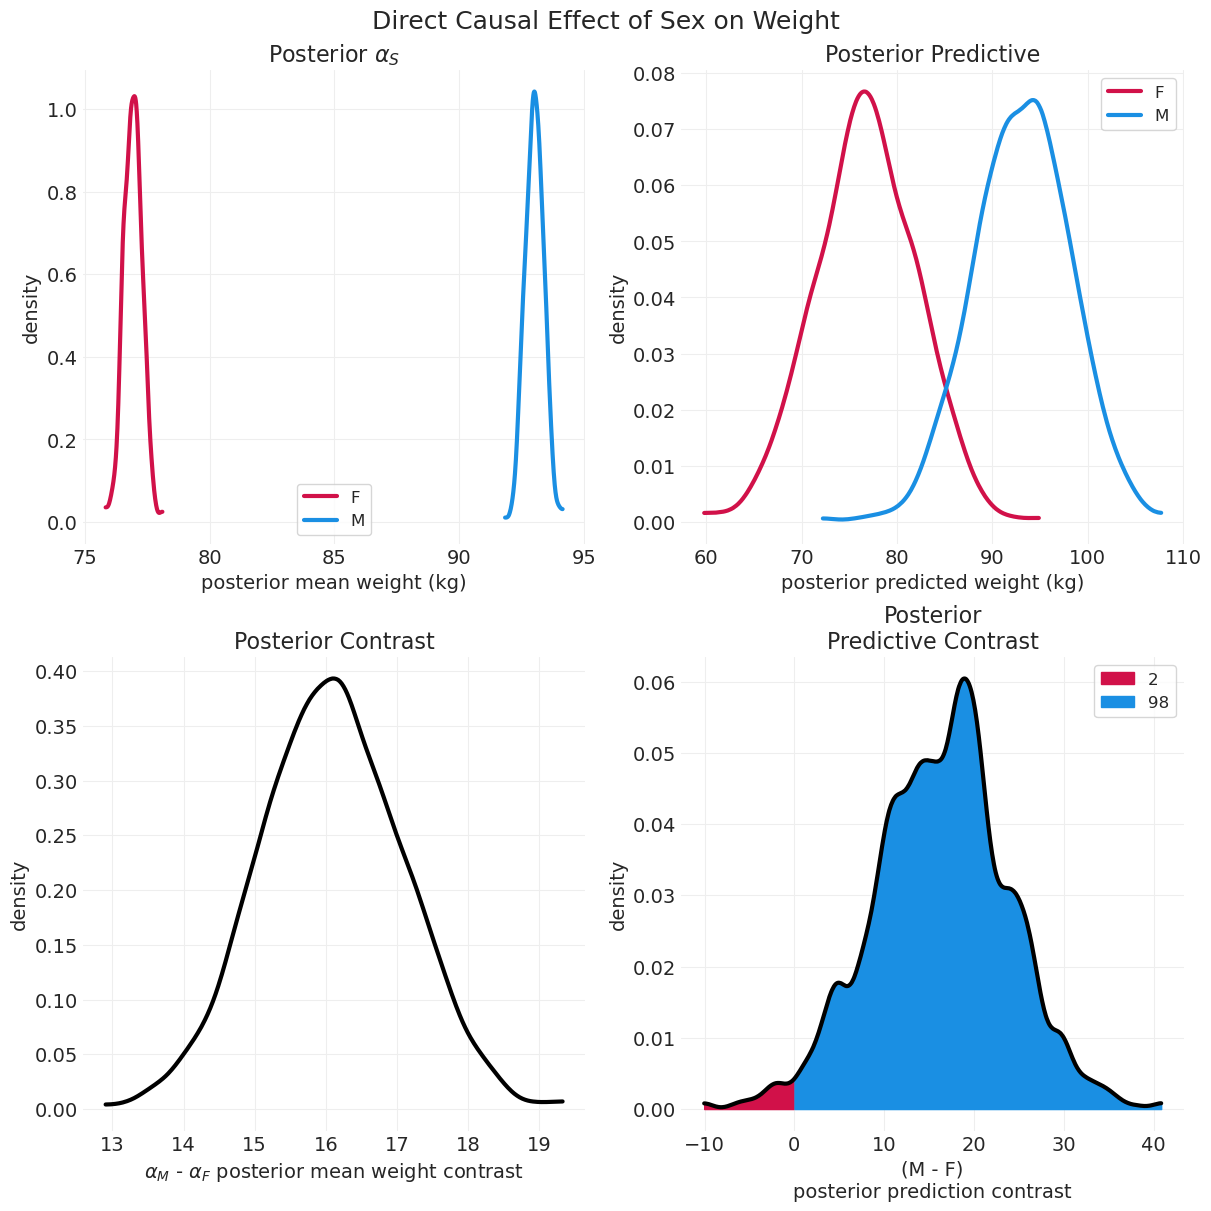

In [27]:
plot_model_posterior(direct_effect_simulated_inference, "Direct")

#### Analyze the real sample

In [28]:
direct_effect_howell_inference, direct_effect_howell_model = fit_direct_effect_weight_model(ADULT_HOWELL)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


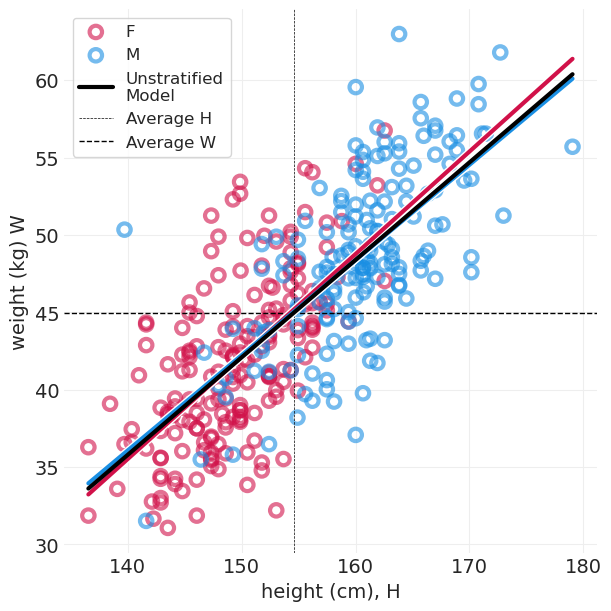

In [29]:
plot_posterior_lines(ADULT_HOWELL, direct_effect_howell_inference, True)

##### Contrasts

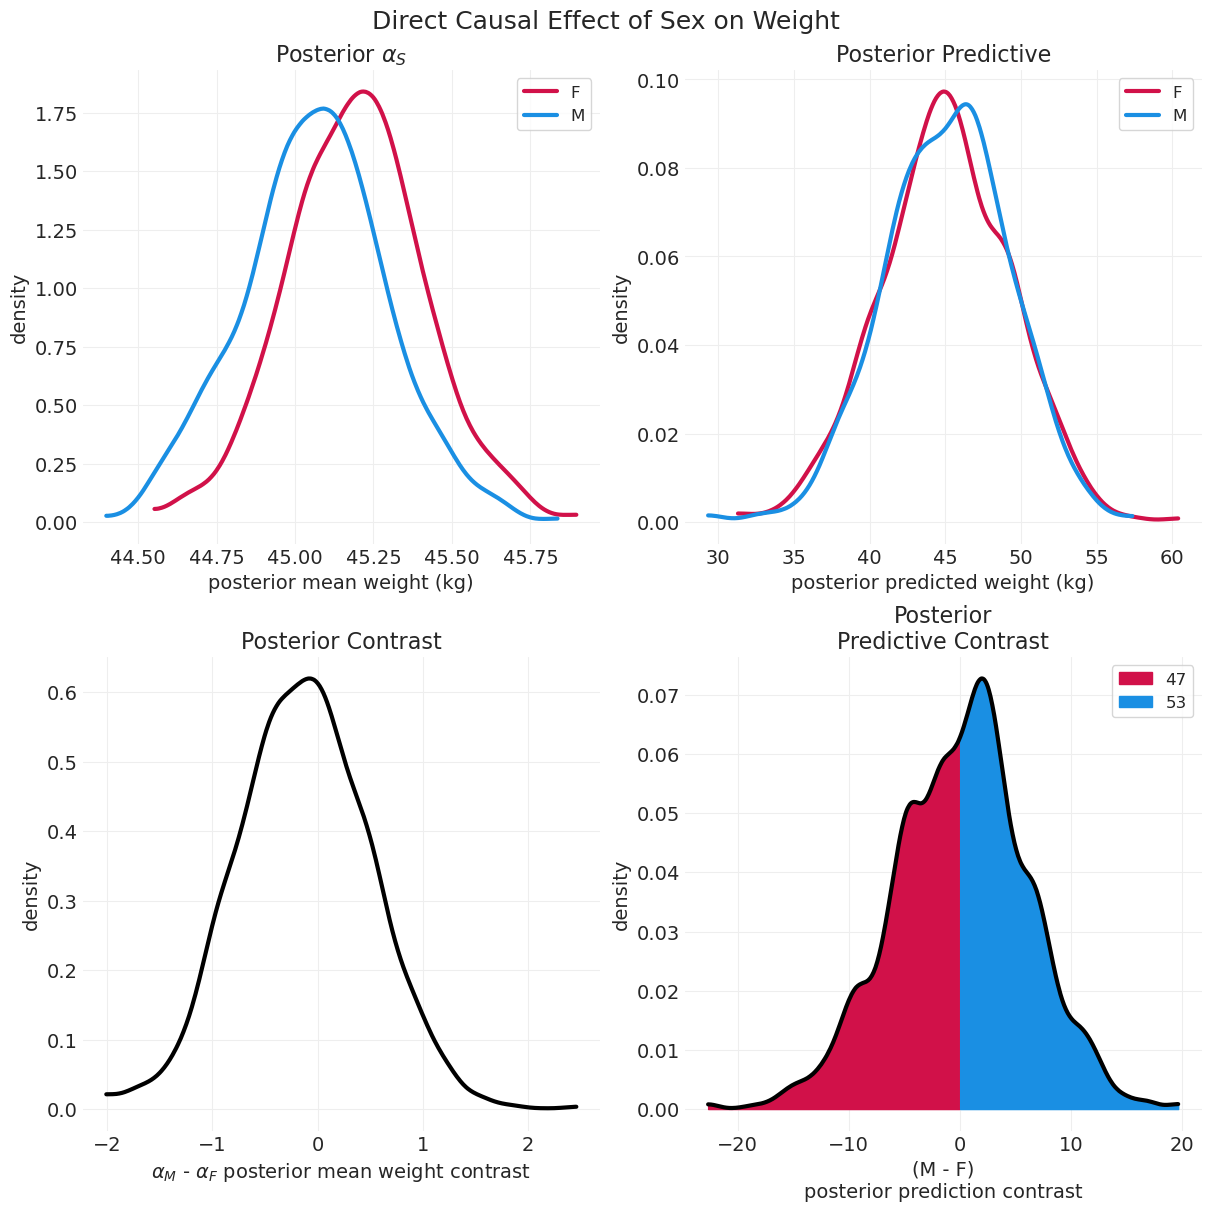

In [30]:
plot_model_posterior(direct_effect_howell_inference, "Direct")

#### Contrast at each height

In [31]:
def plot_heightwise_contrast(model, inference):
    heights = np.linspace(130, 190, 100)
    ppds = {}
    for ii, s in enumerate(['F', 'M']):
        with model:
            pm.set_data(
                {
                    "S": np.ones_line(heights).astype(int) * ii,
                    "H": heights,
                    "Hbar": heights.mean()
                }
            )
            ppds[s] = pm.sample_posterior_predictive(inference, extend_inferencedata=False).posterior_predictive["W_obs"]
    
    ppd_contrast = ppds['M'] - ppds['F']
    
    # Plot contours
    for prob in [.5, .75, .95, .99]:
        az.plot_hdi(heights, ppd_contrast, hdi_prob = prob, color = "gray")